<h2>Binary classification considering toxicity features</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)


from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint, loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, uniform
from sklearn.svm import LinearSVC, SVC



In [3]:
df = pd.read_csv("../file_csv/df_users_annotated_10.csv")

In [4]:
df = df.rename(columns={"cluster_0": "extreme_toxic_group", "cluster_2":"moderated_toxic_group", "cluster_3":"obscene_toxic_group"})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15721 entries, 0 to 15720
Columns: 185 entries, author to toxic_annotation
dtypes: float64(122), int64(59), object(4)
memory usage: 22.2+ MB


In [6]:
df["toxic_annotation"].value_counts()

toxic_annotation
non-toxicity    7878
vulgarity       7496
harassment       297
racism            34
violence          16
Name: count, dtype: int64

In [7]:
#authors are non-toxic if their highest average is not toxic
def toxic_author(aut):
    if aut == "non-toxicity":
        return 0
    else:
        return 1


In [8]:
df["toxic"] = df["toxic_annotation"].apply(toxic_author)
mapping = {0:"non-toxic", 1:"toxic"}
df["toxic"] = df["toxic"].map(mapping)

In [9]:
df["toxic"].value_counts()
#balanced

toxic
non-toxic    7878
toxic        7843
Name: count, dtype: int64

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_5572/3972484360.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='toxicity', y='count', data=counts_df, palette = "colorblind")


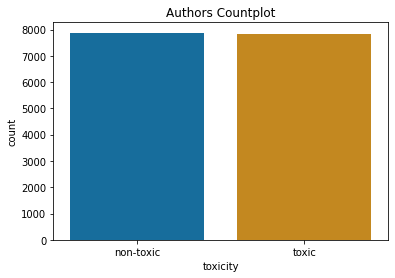

In [10]:
#Countplot
counts = df['toxic'].value_counts()


counts_df = counts.reset_index()
counts_df.columns = ['toxicity', 'count']


sns.barplot(x='toxicity', y='count', data=counts_df, palette = "colorblind")


plt.title("Authors Countplot")
plt.show()


## boxplot per feature

The more separation you see between the boxes, the stronger the 'predictive power' of the covariate.

<Axes: xlabel='perc', ylabel='toxic'>

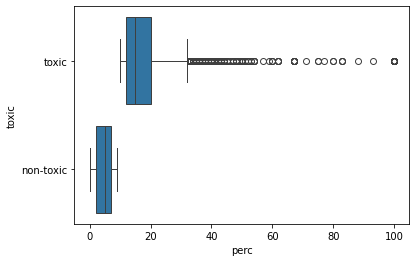

In [11]:
sns.boxplot(data=df, x="perc", y="toxic")

In [12]:

X = df.drop(columns=["author","emotion_list","tox_list","toxic","toxic_annotation","perc"])
X_list = X.columns.to_list()
y = df["toxic"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
mutual_info = mutual_info_classif(X_train, y_train)

In [15]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

toxicity_mean           0.510503
obscene_mean            0.459811
insult_mean             0.457088
tox_over                0.455367
severe_toxicity_mean    0.359352
                          ...   
emoji_count_min         0.000000
fear_min                0.000000
anticip_min             0.000000
surprise_min            0.000000
coleman_liau_max        0.000000
Length: 180, dtype: float64

In [16]:
sel_cols = SelectKBest(mutual_info_classif, k=18) #seleziono quelle >= 0.1
sel_cols.fit(X_train, y_train)
mut_info_feature = X_train.columns[sel_cols.get_support()].to_list()

In [17]:
mut_info_feature

['toxic_posts',
 'extreme_toxic_group',
 'severe_toxicity_sum',
 'insult_sum',
 'toxic_sum',
 'fuckin_sum',
 'toxicity_mean',
 'severe_toxicity_mean',
 'obscene_mean',
 'threat_mean',
 'insult_mean',
 'identity_attack_mean',
 'toxicity_max',
 'severe_toxicity_max',
 'obscene_max',
 'insult_max',
 'tox_over',
 'ratio_toxic']

In [18]:
'''
for i in X_list:
    plt.figure()
    sns.boxplot(data=df, x=i, y="toxic")
'''

'\nfor i in X_list:\n    plt.figure()\n    sns.boxplot(data=df, x=i, y="toxic")\n'

In [19]:
#feature extraction tramite boxplot
boxplot_feat = ["toxic_posts","extreme_toxic_group","moderated_toxic_group","obscene_toxic_group","toxicity_sum","severe_toxicity_sum","obscene_sum","threat_sum","insult_sum","identity_attack_sum","toxic_sum","dumb_sum","shit_sum","fuckin_sum","fucking_sum","racist_sum","fuck_sum","bitch_sum","toxicity_mean","severe_toxicity_mean","obscene_mean","insult_mean","identity_attack_mean","disgust_mean","severe_toxicity_max","threat_max","insult_max","identity_attack_max","fear_max","tox_over"]

In [20]:
features_impo = list(set(mut_info_feature) | set(boxplot_feat))

In [21]:
len(features_impo)

34

In [22]:
features_impo

['moderated_toxic_group',
 'toxicity_max',
 'extreme_toxic_group',
 'ratio_toxic',
 'toxicity_mean',
 'bitch_sum',
 'toxicity_sum',
 'identity_attack_sum',
 'toxic_sum',
 'obscene_toxic_group',
 'threat_mean',
 'insult_mean',
 'obscene_mean',
 'severe_toxicity_max',
 'toxic_posts',
 'fuck_sum',
 'insult_sum',
 'racist_sum',
 'fucking_sum',
 'shit_sum',
 'obscene_max',
 'fear_max',
 'disgust_mean',
 'insult_max',
 'severe_toxicity_mean',
 'obscene_sum',
 'tox_over',
 'threat_max',
 'dumb_sum',
 'threat_sum',
 'fuckin_sum',
 'identity_attack_mean',
 'identity_attack_max',
 'severe_toxicity_sum']

In [23]:
features_impo.remove("toxic_sum")

## Training/Test set split

In [24]:
X_sel = df.loc[:,features_impo]
y = df["toxic"]

In [25]:
X_sel.shape, y.shape

((15721, 33), (15721,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=42)

In [27]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((4717, 33), (11004, 33), (11004,), (4717,))

## DT

In [28]:
'''
param_grid = {
    "min_samples_split": uniform(0.0005,0.0003),
    "min_samples_leaf": uniform(0.004, 0.001),
    "max_depth": randint(2, 150),
    "criterion": ["gini", "entropy", "log_loss"],
    #"min_weight_fraction_leaf" : uniform(0.0001, 1e0),
    #"max_leaf_nodes" : randint(80, 140),
    #"min_impurity_decrease" : uniform(0.0001, 1e0),
    "ccp_alpha" : uniform(0.002, 0.0005)
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "min_samples_split": uniform(0.0005,0.0003),\n    "min_samples_leaf": uniform(0.004, 0.001),\n    "max_depth": randint(2, 150),\n    "criterion": ["gini", "entropy", "log_loss"],\n    #"min_weight_fraction_leaf" : uniform(0.0001, 1e0),\n    #"max_leaf_nodes" : randint(80, 140),\n    #"min_impurity_decrease" : uniform(0.0001, 1e0),\n    "ccp_alpha" : uniform(0.002, 0.0005)\n}\ngrid = RandomizedSearchCV(\n    DecisionTreeClassifier(),\n    param_distributions=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=500,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [29]:
#print(grid.best_params_, grid.best_score_)

In [30]:
#decision tree
dt = DecisionTreeClassifier(ccp_alpha = 0.0022, max_depth = 117, criterion = "gini", min_samples_leaf=0.0049,random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.9400042399830401
F1-score [0.94110302 0.93886369]
              precision    recall  f1-score   support

   non-toxic      0.939     0.943     0.941      2397
       toxic      0.941     0.937     0.939      2320

    accuracy                          0.940      4717
   macro avg      0.940     0.940     0.940      4717
weighted avg      0.940     0.940     0.940      4717



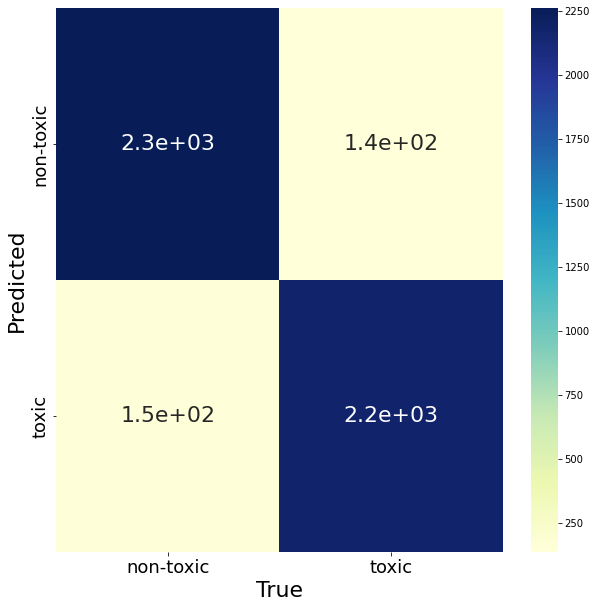

In [31]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

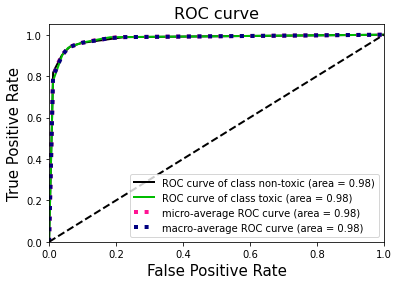

In [32]:
plt.figure(figsize = (10,10))
plot_roc(y_test, dt.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

## KNN


In [33]:
#Scaling only on training set for entropy reasons
norm = StandardScaler()
norm.fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)


In [34]:
'''
param_grid = {
    "n_neighbors": randint(12,60),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean", "minkowski"]
}

grid = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter = 50,
)
grid.fit(X_train_norm, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "n_neighbors": randint(12,60),\n    "weights": ["uniform", "distance"],\n    "metric": ["manhattan", "euclidean", "minkowski"]\n}\n\ngrid = RandomizedSearchCV(\n    KNeighborsClassifier(),\n    param_distributions=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter = 50,\n)\ngrid.fit(X_train_norm, y_train)\nclf = grid.best_estimator_\n'

In [35]:
#print(grid.best_params_, grid.best_score_)

In [36]:
knn = KNeighborsClassifier(n_neighbors=34, metric="manhattan", weights = "distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.8753444986220055
F1-score [0.87631468 0.87435897]
              precision    recall  f1-score   support

   non-toxic      0.884     0.869     0.876      2397
       toxic      0.867     0.882     0.874      2320

    accuracy                          0.875      4717
   macro avg      0.875     0.875     0.875      4717
weighted avg      0.875     0.875     0.875      4717



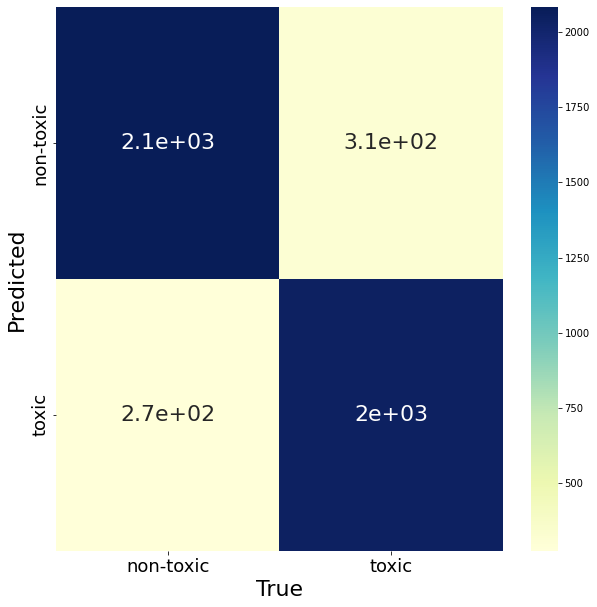

In [37]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

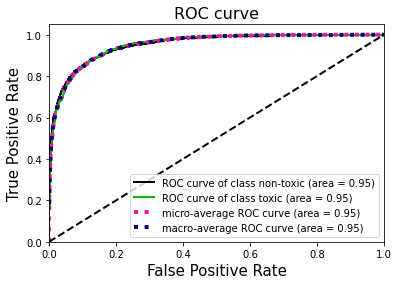

In [38]:
plt.figure(figsize = (10,10))
plot_roc(y_test, knn.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

## Random Forest

In [39]:
'''
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion': ["gini", "entropy"], # log_loss doesn't work
              'max_features': ["sqrt", "log2", None],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)],
              'class_weight': ["balanced", None, "balanced_subsample"]
             }

grid_rdmforest = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=100)
grid_rdmforest.fit(X_train, y_train)
'''

'\nparam_list = {\'min_samples_split\': [2, 5, 10, 20],\n              \'min_samples_leaf\': [1, 5, 10, 20],\n              \'criterion\': ["gini", "entropy"], # log_loss doesn\'t work\n              \'max_features\': ["sqrt", "log2", None],\n              \'n_estimators\': [int(x) for x in np.linspace(100,1000,num=10)],\n              \'class_weight\': ["balanced", None, "balanced_subsample"]\n             }\n\ngrid_rdmforest = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=100)\ngrid_rdmforest.fit(X_train, y_train)\n'

In [40]:
rf = RandomForestClassifier(n_estimators=1000, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0, 
                             n_jobs=-1,
                             class_weight="balanced_subsample")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.9510281958872164
F1-score [0.9518449  0.95018331]
              precision    recall  f1-score   support

   non-toxic      0.951     0.952     0.952      2397
       toxic      0.951     0.950     0.950      2320

    accuracy                          0.951      4717
   macro avg      0.951     0.951     0.951      4717
weighted avg      0.951     0.951     0.951      4717



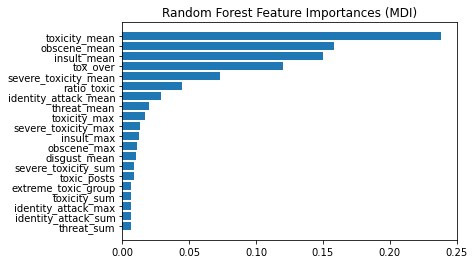

In [41]:
nbr_features = 20

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_sel.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

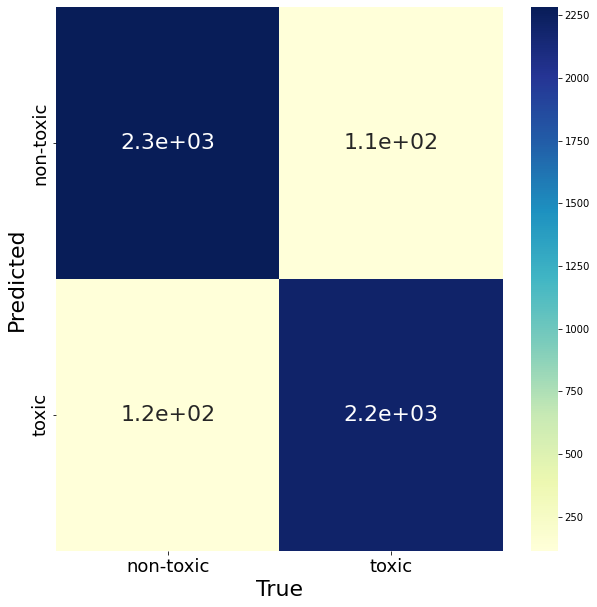

In [42]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

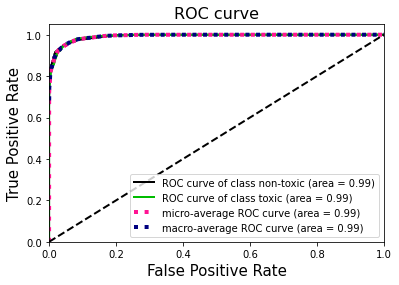

In [43]:
plt.figure(figsize = (10,10))
plot_roc(y_test, rf.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

## SVM


In [44]:
svm = LinearSVC(C=0.07, class_weight = "balanced", random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.9300402798388806
F1-score [0.93209877 0.92785308]
              precision    recall  f1-score   support

   non-toxic      0.920     0.945     0.932      2397
       toxic      0.941     0.915     0.928      2320

    accuracy                          0.930      4717
   macro avg      0.931     0.930     0.930      4717
weighted avg      0.930     0.930     0.930      4717



/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


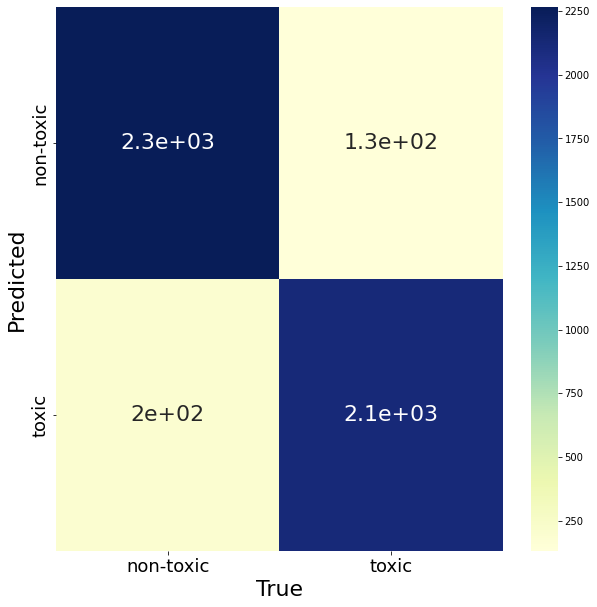

In [45]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

In [46]:
#y_score.shape

# Logistic Regression

In [47]:
'''
param_grid = {
    "multi_class": ["multinomial", "ovr"],
    "C": loguniform(1e-5, 1),
    "class_weight": [None, "balanced"],
}
grid = RandomizedSearchCV(
    LogisticRegression(solver="saga"),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "multi_class": ["multinomial", "ovr"],\n    "C": loguniform(1e-5, 1),\n    "class_weight": [None, "balanced"],\n}\ngrid = RandomizedSearchCV(\n    LogisticRegression(solver="saga"),\n    param_distributions=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=100,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [48]:
log_reg = LogisticRegression(C=0.05, multi_class='multinomial', solver='saga', class_weight="balanced", max_iter=10000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.920500317998728
F1-score [0.92285538 0.91799694]
              precision    recall  f1-score   support

   non-toxic      0.910     0.936     0.923      2397
       toxic      0.932     0.905     0.918      2320

    accuracy                          0.921      4717
   macro avg      0.921     0.920     0.920      4717
weighted avg      0.921     0.921     0.920      4717



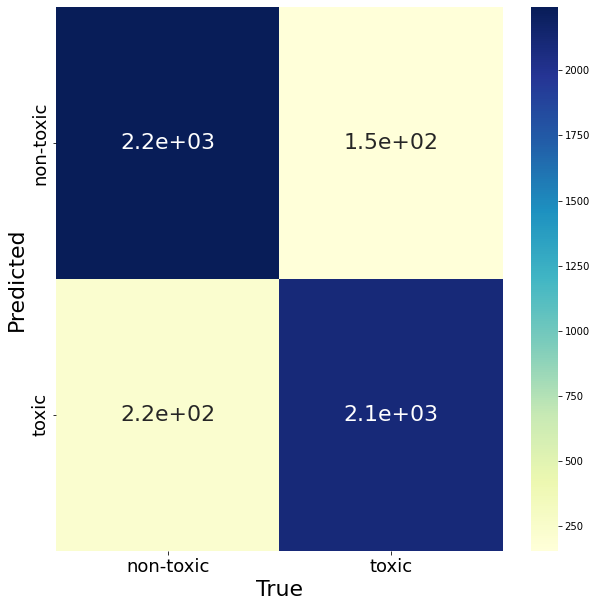

In [49]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

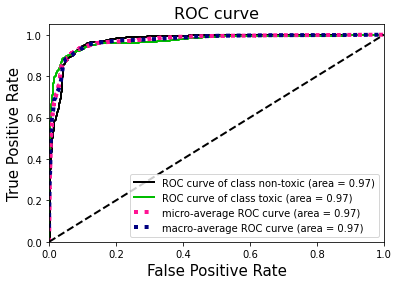

In [50]:
plt.figure(figsize = (10,10))
plot_roc(y_test, log_reg.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

# XAI

## shap local

In [51]:
#shap import
import shap
shap.initjs()

In [52]:
#functions that return predict and predict probability
def bb_predict(X_pre,model):
    return model.predict(X_pre)

def bb_predict_proba(X_pre,model):
    return model.predict_proba(X_pre)

In [53]:
#predict proba Random Forest
prob_class = bb_predict_proba(X_test, rf)
diff = np.abs(prob_class[:, 0] - prob_class[:, 1])

# Trovare gli indici dove la differenza è inferiore a 0.1
indices_rf = set(np.where(diff < 0.11)[0])


In [54]:
#predict proba KNN
prob_class = bb_predict_proba(X_test, knn)
diff = np.abs(prob_class[:, 0] - prob_class[:, 1])

# Trovare gli indici dove la differenza è inferiore a 0.1
indices_knn = set(np.where(diff < 0.11)[0])


In [55]:
prob_class = bb_predict_proba(X_test, log_reg)
diff = np.abs(prob_class[:, 0] - prob_class[:, 1])

# Trovare gli indici dove la differenza è inferiore a 0.1
indices_log_reg = set(np.where(diff < 0.11)[0])


In [56]:
indices = indices_knn & indices_log_reg & indices_rf
indices_list = list(indices)

In [57]:
indices_list

[2066]

In [ ]:
riga_2 = 3992

In [ ]:
X_test.values[riga]

In [ ]:
X_test.iloc[3992]

In [ ]:
df.iloc[9520,185] 

In [ ]:
#predizioni secondo i modelli
y_pred_knn = knn.predict(X_test)
print("knn:", y_pred_knn[3992])

y_pred_log_reg = log_reg.predict(X_test)
print("log_reg:", y_pred_log_reg[3992])

y_pred_rf = rf.predict(X_test)
print("rf:",y_pred_rf[3992])

In [ ]:
y_pred_knn_prob = knn.predict_proba(X_test)
print("knn:", y_pred_knn_prob[3992])

In [ ]:
y_pred_log_reg_prob = log_reg.predict_proba(X_test)
print("log_reg:", y_pred_log_reg_prob[3992])

In [ ]:
y_pred_rf_prob = rf.predict_proba(X_test)
print("rf:", y_pred_rf_prob[3992])

In [ ]:
def xai_plot(record, clf):
    i2e = record
    x = X_test.values[i2e]
    
    f = lambda x: bb_predict_proba(x,clf)[:, 1]
    med = np.median(X_train, axis=0).reshape((1, X_train.shape[1]))

    shap_explainer = shap.KernelExplainer(f, med)
    
    shap_values_single = shap_explainer.shap_values(x, nsamples=1000)
    
    
    return shap.plots._waterfall.waterfall_legacy(shap_explainer.expected_value, shap_values_single, feature_names = X_test.columns,max_display=10)

Force plot gives us the explainability of a single model prediction.<br> In this plot, we can see how features contributed to the model’s prediction for a specific observation. <br> It is very convenient to use for error analysis or a deep understanding of a particular case.

In [ ]:
xai_plot(riga_2, knn)

In [ ]:
xai_plot(riga_2, rf)

In [ ]:
xai_plot(riga_2, log_reg)

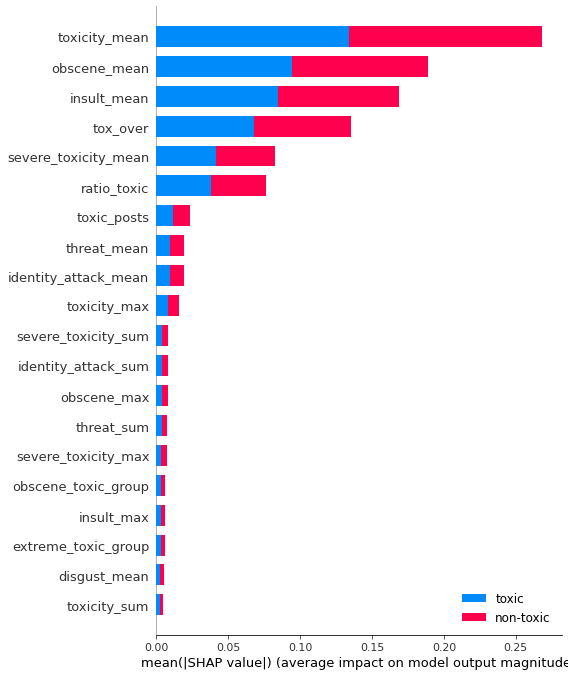

CPU times: user 19min 43s, sys: 6.74 s, total: 19min 50s
Wall time: 19min 51s


In [59]:

%%time
#SUMMARY PLOT RF
class_names = ["non-toxic","toxic"]

explainer = shap.TreeExplainer(rf)

# Calcola i valori SHAP per il set di test
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=class_names, feature_names = X_test.columns)


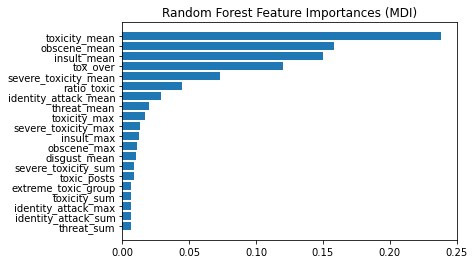

In [60]:
nbr_features = 20

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_sel.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()
